<a href="https://colab.research.google.com/github/mikypet/Pycollection/blob/master/Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### MOUNT THE DATASOURCE AND INSTALL PYSPARK

---



In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 38 kB/s 
     |████████████████████████████████| 198 kB 61.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=f9790456efe11cff5bcb37b7e3436f2676efbe2489bc2cbe3d7c9ebb9e1c135a
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


Using UNSW-NB15 dataset for intrusion detection. The goal is to predict whether there could be an attack or not using the dataset.

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import NullType
from pyspark.sql.functions import when
from pyspark.sql.functions import trim
# INTRODUCING NUMPY AND PANDA TO ACHIEVE PRETTY OUTLOOK AND EXTENDED FUNCTIONALITIES
# linear algebra AND data processing, CSV file I/O respectiveky
import numpy as np 
import pandas as pd # 

In [4]:
spark = SparkSession.builder.appName("Classifiers").getOrCreate()

In [6]:
data_features = spark.read.csv('/gdrive/My Drive/Dataset/UNSW-NB15_features.csv', header = True, inferSchema = True)
data_features.printSchema()

data_features.show(49,truncate = False)

root
 |-- No.: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Type : string (nullable = true)
 |-- Description: string (nullable = true)

+---+----------------+---------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|No.|Name            |Type     |Description                                                                                                                                                       |
+---+----------------+---------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1  |srcip           |nominal  |Source IP address                                                                                                                                                 |
|2  |sport           |integer  |Source port number        

In [7]:
data_events = spark.read.csv('/gdrive/My Drive/Dataset/UNSW-NB15_LIST_EVENTS.csv', header = True, inferSchema = True)
data_events.printSchema()

root
 |-- Attack category: string (nullable = true)
 |-- Attack subcategory: string (nullable = true)
 |-- Number of events: integer (nullable = true)



In [8]:
# mapping the data to the features from the features dataset
data_pyspark = spark.read.csv('/gdrive/My Drive/Dataset/UNSW-NB15.csv', header = True, inferSchema = True).toDF(
    'srcip','sport','dstip','dsport','proto','state','dur','sbytes','dbytes','sttl','dttl','sloss','dloss',
    'service','Sload','dload','Spkts','Dpkts','swin','dwin','stcpb','dtcpb','smeansz','dmeansz','trans_depth','res_bdy_len',
    'Sjit','Djit','Stime','Ltime',    'Sintpkt','Dintpkt','tcprtt','synack','ackdat','is_sm_ips_ports','ct_state_ttl',
    'ct_flw_http_mthd','is_ftp_login','ct_ftp_cmd','ct_srv_src','ct_srv_dst','ct_dst_ltm',
    'ct_src_ltm','ct_src_dport_ltm','ct_dst_sport_ltm','ct_dst_src_ltm','attack_cat','Label')

### UNDERSTANDING THE DATASET

In [ ]:
data_pyspark.printSchema()

Analysis of the schema show we have int, long, double and string datatypes represented in the dataset. Therefore we will get the numeric datatypes for dataset description.

In [8]:
data_pyspark = data_pyspark.drop('srcip','dstip','sport','dsport','proto')
numeric_features = [t[0] for t in data_pyspark.dtypes if t[1] == 'int' or t[1] == 'long'or t[1] == 'double']
data_pyspark.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
dur,2539738,0.6588633347840528,13.92577037447336,0.0,8786.6377
sbytes,2539738,4340.070896289302,56409.409186153316,0,14355774
dbytes,2539738,36432.01927679154,161105.33522674238,0,14657531
sttl,2539738,62.78151053376372,74.6267115956767,0,255
dttl,2539738,30.770441675479912,42.851930611408726,0,254
sloss,2539738,5.164537444413558,22.5183674285243,0,5319
dloss,2539738,16.331417650167065,56.597900641709714,0,5507
Sload,2539738,3.6949293912529E7,1.1860415895657778E8,0.0,5.9880003E9
dload,2539738,2451159.3445124477,4225033.483855149,0.0,1.287619E8


In [ ]:
print(numeric_features)

['sport', 'dsport', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'Label']


The Schema of the dataset, attack_cat and Label can be infered as the output variable while the rest of the features can be categories as input variable.
**Input Vaiables:** attack_cat,Label

selecting the first five records for study

In [10]:
#import pandas as pd
#pd.DataFrame(data_pyspark.take(5), columns=data_pyspark.columns).transpose()
data_pyspark.show(2)
data_pyspark.filter(data_pyspark.service == '-').show(2)
data_pyspark.filter(data_pyspark.attack_cat.isNull()).show(2)

+-----+-----------+------+------+----+----+-----+-----+-------+---------+---------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+---------+---------+----------+----------+--------+----------+-------+------------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+
|state|        dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|    Sload|    dload|Spkts|Dpkts|swin|dwin|     stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit|     Stime|     Ltime| Sintpkt|   Dintpkt| tcprtt|      synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+-----+-----------+------+------+----+----+-----+-----+-------+---------+---------+-----+-----+----+----+----------+------

attack_cat features contains nulls. null values should be changes to something more relatable to the model.
service features conatain '-' it should be changed to something more relatable also.

#### CORRELATION BETWEEN THE INDEPENDENT VARIABLES

To provides quantitative measurements of the statistical dependence between the features in the dataset. This will mean exploring the ML sublibrary of pyspark. Using the attack recordset, I will have to repair the dataset and convert to vector column to do this

**CORRELATION BY PEARSON**

In [77]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [ ]:
## Replacing nulls with "Normal"
Cor_data = data_pyspark.na.fill('Normal',['attack_cat'])
## correct Backdoor to Backdoors
Cor_data = Cor_data.withColumn("attack_cat", when(trim(Cor_data.attack_cat) == "Backdoor","Backdoors") \
      .otherwise(trim(Cor_data.attack_cat)))
## correct - to NA
Cor_data = Cor_data.withColumn("service", when(Cor_data.service == "-","NA") \
      .otherwise(Cor_data.service))
## Drop string features
Cor_data = Cor_data.drop('srcip','dstip','sport','dsport','proto')



In [ ]:
from pyspark.ml.feature import StringIndexer
stringIndexer = StringIndexer(inputCols=['state','service','attack_cat'], outputCols=['stateindex','serviceindex','attack_catindex'])
model = stringIndexer.fit(Cor_data)
Transcor_data = model.transform(Cor_data)

# droping the unindexed fields
Transcor_data = Transcor_data.drop('state','service','attack_cat')



In [80]:
# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=Transcor_data.columns, outputCol=vector_col)
df_vector = assembler.transform(Transcor_data).select(vector_col)

# get correlation matrix
pearsonCorr = Correlation.corr(df_vector, vector_col,'pearson')
pearsonCorr.show()

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [24]:
pearsonCorr.collect()[0]["pearson({})".format(vector_col)].values

array([ 1.        ,  0.03326869,  0.08696994, ...,  0.28683485,
       -0.03902499,  1.        ])

**CORRELATION BY SCATTER MATRIX**

due to the volume of our dataset and the effect of such volume on space, correlation will be demonstrated on 10% sample of the dataset

In [11]:
numeric_features = [t[0] for t in Cor_data.dtypes if t[1] == 'int' or t[1] == 'long'or t[1] == 'double']
numeric_data = Cor_data.sample(0.1).select(numeric_features).toPandas()

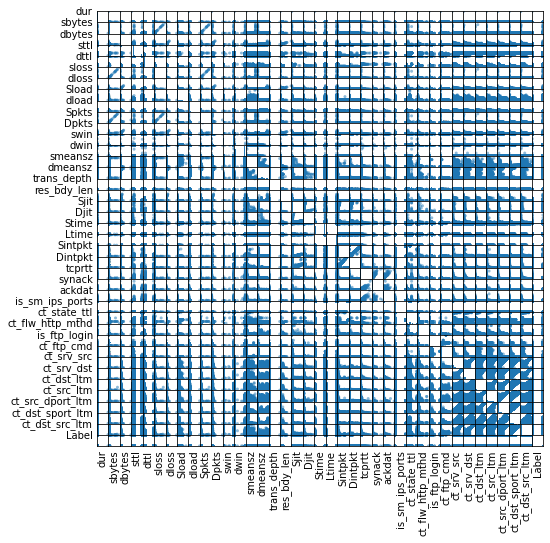

In [12]:
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [ ]:
print('Covariance Matrix:',np.cov(Cor_data))

The numeric features show low correlation as such all numeric features qaulifies for the model. However few repairs of the dataset is required

### HYPOTHESIS TESTING

In [93]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.feature import VectorIndexer,VectorAssembler
from pyspark.ml import Pipeline

In [94]:
categoryindexer = StringIndexer(
  inputCols = ["state",'service','ct_state_ttl','ct_flw_http_mthd','is_ftp_login','ct_ftp_cmd','ct_srv_src','ct_srv_dst','ct_dst_ltm',
    'ct_src_ltm','ct_src_dport_ltm','ct_dst_sport_ltm','ct_dst_src_ltm',"attack_cat"]
  , outputCols = ["state_index","service_index",'ct_state_ttl_index','ct_flw_http_mthd_index',
                  'is_ftp_login_index','ct_ftp_cmd_index','ct_srv_src_index','ct_srv_dst_index','ct_dst_ltm_index',
    'ct_src_ltm_index','ct_src_dport_ltm_index','ct_dst_sport_ltm_index','ct_dst_src_ltm_index',"attack_cat_index"]
)

assembler = VectorAssembler(
  inputCols = ["state_index","service_index",'ct_state_ttl_index','ct_flw_http_mthd_index',
                  'is_ftp_login_index','ct_ftp_cmd_index','ct_srv_src_index','ct_srv_dst_index','ct_dst_ltm_index',
    'ct_src_ltm_index','ct_src_dport_ltm_index','ct_dst_sport_ltm_index','ct_dst_src_ltm_index',"attack_cat_index"]
  , outputCol = "features"
)

pipeline = Pipeline(stages = [categoryindexer, assembler]) 
model = pipeline.fit(Cor_data)
transformed = model.transform(Cor_data).select('features','Label')



In [97]:
from numpy.core.numeric import False_
r = ChiSquareTest.test(transformed, "features", "Label")
r.show(truncate = True)


res = r.head()
print("pValues: " + str(res.pValues))
print("degreesOfFreedom: " + str(res.degreesOfFreedom))
print("statistics: " + str(res.statistics))

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+--------------------+--------------------+--------------------+
|             pValues|    degreesOfFreedom|          statistics|
+--------------------+--------------------+--------------------+
|[0.0,0.0,0.0,0.0,...|[15, 12, 6, 15, 3...|[907539.284195906...|
+--------------------+--------------------+--------------------+

pValues: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
degreesOfFreedom: [15, 12, 6, 15, 3, 7, 64, 65, 61, 61, 61, 54, 64, 9]
statistics: [907539.2841959061,230558.47962189929,2268408.3367428533,5012.23558323105,2725.478529195289,2771.0806758175295,510642.34059513826,537273.3253034686,567871.0124321447,531349.4121990484,692053.6894357714,737997.0676973698,632628.5777436411,2539738.0]


### DATASET PREPARATION FOR MACHINE LEARNING

It is clear from above that service feature contains unwanted value and attack_category conatinas null values. we will therefore update this data with relevant values for the model and finally drop string columns

In [9]:
## Replacing nulls with "Normal"
data_pyspark2 = data_pyspark.na.fill('Normal',['attack_cat'])

In [10]:
## correct Backdoor to Backdoors
data_pyspark2 = data_pyspark2.withColumn("attack_cat", when(trim(data_pyspark2.attack_cat) == "Backdoor","Backdoors") \
      .otherwise(trim(data_pyspark2.attack_cat)))

In [11]:
## correct - to NA
data_pyspark2 = data_pyspark2.withColumn("service", when(data_pyspark2.service == "-","NA") \
      .otherwise(data_pyspark2.service))

In [12]:
## Drop string features
data_pyspark2 = data_pyspark2.drop('srcip','dstip','sport','dsport','proto')

In [13]:

datagroupby = data_pyspark2.groupBy(trim(data_pyspark2.attack_cat)).count().alias('Count')
datagroupby.show()

+----------------+-------+
|trim(attack_cat)|  count|
+----------------+-------+
|           Worms|    174|
|       Shellcode|   1511|
|       Backdoors|   2329|
|         Fuzzers|  24246|
|        Analysis|   2677|
|             DoS|  16353|
|  Reconnaissance|  13987|
|        Exploits|  44525|
|          Normal|2218455|
|         Generic| 215481|
+----------------+-------+



The process further includes Category Indexing, One-Hot Encoding and VectorAssembler (a feature transformer that will merges the columns into a vector column).

StringIndexer will index each category column and then will be converted into one-hot encoded variables. The resulting output has the binary vectors appended to the end of each row. We use the StringIndexer again to encode our Labels to label indices. Next, we use the VectorAssembler to combine all the feature columns into a single vector column.

### BINOMIAL LOGISTIC REGRESSION MODEL (Binary Classification)

##### PIPELINE AND SPLIT DATASET INTO TRAIN AND TEST SET

In [22]:
#Binomial data prepration
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.feature import OneHotEncoder
stages = []
categoricalColumns = ['proto', 'state','service', 'attack_cat']

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(
        inputCols=[stringIndexer.getOutputCol()], 
        outputCols=[categoricalCol + "classVec"]
    )
    # stage 1
    stages += [stringIndexer, encoder]
    
label_stringIdx = StringIndexer(inputCol = 'Label', outputCol = 'label')
    # stage 2
stages += [label_stringIdx]
numericCols = ['dsport', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss',
               'Sload', 'dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'smeansz', 'dmeansz', 'trans_depth',
               'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack',
               'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
               'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm',
               'ct_dst_sport_ltm', 'ct_dst_src_ltm']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    # stage 2
stages += [assembler]

Pipeline will be used to chain all the stages for a single more resillient processing of the dataset with a fit and transform operation

Splitting dataset into trainset and testset respectively and 30% held out for testing, using seed in other to be able to replicate the splitting in the future

In [32]:
#Binomial data prepration

from pyspark.ml import Pipeline

Binomialdata = data_pyspark2

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(Binomialdata)
Binomialdata = pipelineModel.transform(Binomialdata)
selectedCols = ['label', 'features']
data_pyspark3 = Binomialdata.select(selectedCols)
data_pyspark3.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



In [25]:
trainset, testset = data_pyspark3.randomSplit([0.7, 0.3], seed = 2021)
print("Training Dataset Count: " + str(trainset.count()))
print("Test Dataset Count: " + str(testset.count()))

Training Dataset Count: 1777507
Test Dataset Count: 762231


In [26]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(trainset)

**SUMMARY:** Coefficients by using LogisticRegressionModel’s attributes.

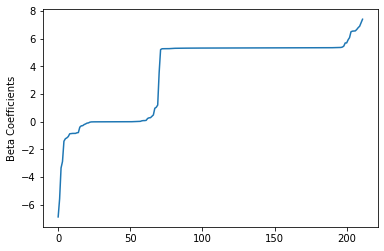

In [27]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()


**SUMMARY:** Obtaining the ROC Receiver-Operating Characteristic and the Area under ROC (areaUnderROC).

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


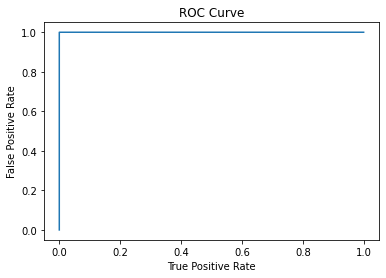

Training Set areaUnderROC: 0.9999864242380915


In [28]:
trainingSummary = lrModel.summary
lrROC = trainingSummary.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training Set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


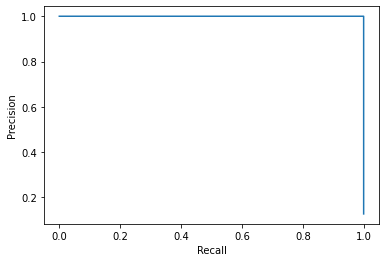

Quantifies the number of correct positive predictions made vs what was made out of the dataset
Accuracy of the training: 0.9999887482862233


In [29]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()
print('Accuracy of the training: '+ str(trainingSummary.accuracy))

**Predition:** Predicting with the test Dateset

In [16]:
lrPreds = lrModel.transform(testset)
lrPreds.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[7.12580303641990...|       0.0|[0.99919655899688...|
|  0.0|[7.60627046673172...|       0.0|[0.99950292402000...|
|  0.0|[7.48662341714987...|       0.0|[0.99943978156767...|
|  0.0|[7.45663146724366...|       0.0|[0.99942273486969...|
|  0.0|[5.94679952892587...|       0.0|[0.99739262239466...|
|  0.0|[5.92456737920999...|       0.0|[0.99733416187403...|
|  0.0|[5.88873736561613...|       0.0|[0.99723718172889...|
|  0.0|[6.10801003801380...|       0.0|[0.99777996549505...|
|  0.0|[6.16691246839997...|       0.0|[0.99790668840971...|
|  0.0|[6.21289711640005...|       0.0|[0.99800058079303...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



**Evaluation:** Evaluating Logistic Regression Model on the dataset

In [28]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lrEval = BinaryClassificationEvaluator()
print('Test Area Under ROC', lrEval.evaluate(lrPreds))

Test Area Under ROC 0.9999995492031808


### MULTINOMIAL LOGISTIC REGRESSION MODEL (Multiclass Classification)

In [77]:
#Multinomial data prepration
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.feature import OneHotEncoder
pstages = []
pcategoricalColumns = ['proto', 'state','service']

for categoricalCol in pcategoricalColumns:
    pstringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    pencoder = OneHotEncoder(
        inputCols=[pstringIndexer.getOutputCol()], 
        outputCols=[categoricalCol + "classVec"]
    )
    # stage 1
    pstages += [pstringIndexer, pencoder]
    
plabel_stringIdx = StringIndexer(inputCol = 'attack_cat', outputCol = 'label')
    # stage 2
pstages += [plabel_stringIdx]
pnumericCols = ['dsport', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss',
               'Sload', 'dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'smeansz', 'dmeansz', 'trans_depth',
               'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack',
               'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
               'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm',
               'ct_dst_sport_ltm', 'ct_dst_src_ltm','label']
passemblerInputs = [c + "classVec" for c in pcategoricalColumns] + pnumericCols
passembler = VectorAssembler(inputCols=passemblerInputs, outputCol="features")
    # stage 2
pstages += [passembler]

In [78]:
#Multinomial 
from pyspark.ml import Pipeline

Multinomialdata = data_pyspark2

ppipeline = Pipeline(stages = pstages)
ppipelineModel = ppipeline.fit(Multinomialdata)
Multinomialdata = ppipelineModel.transform(Multinomialdata)
pselectedCols = ['label', 'features']
data_pyspark4 = Multinomialdata.select(pselectedCols)
data_pyspark4.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



In [79]:
pdf = pd.DataFrame(data_pyspark4.take(5), columns=data_pyspark4.columns)
pdf.iloc[:,0:2] 


,label,features
0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [80]:
ptrainset, ptestset = data_pyspark4.randomSplit([0.7, 0.3], seed = 2021)
print("Training Dataset Count: " + str(ptrainset.count()))
print("Test Dataset Count: " + str(ptestset.count()))

Training Dataset Count: 1777507
Test Dataset Count: 762231


In [81]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10,  family="multinomial")
lrModel = lr.fit(ptrainset)

**SUMMARY:** Coefficients by using LogisticRegressionModel’s attributes.

In [84]:
# Print the coefficients and intercept for multinomial logistic regression
print("Coefficients: \n" + str(lrModel.coefficientMatrix))
print("Intercept: " + str(lrModel.interceptVector))

trainingSummary = lrModel.summary

Coefficients: 
DenseMatrix([[ 2.22517889e-01,  1.98128734e-01, -6.44119008e+00, ...,
              -4.56727320e-03,  1.26482044e-02, -3.74998712e+00],
             [ 1.47816329e-01,  6.74668927e-03, -1.95540003e+00, ...,
               5.12185864e-02,  1.46688428e-02, -5.50274012e-01],
             [-1.65331411e-01, -2.33137885e-01,  5.60599681e+00, ...,
              -8.41511869e-03, -9.23749808e-03, -5.53657991e-01],
             ...,
             [-5.63726281e-02, -6.81088574e-02,  1.76970675e+00, ...,
              -7.83135285e-04, -1.09295355e-03,  7.68129886e-01],
             [-2.97908899e-02,  5.44835226e-02, -3.62891242e-01, ...,
              -3.62077232e-03, -2.49767495e-03,  8.12242315e-01],
             [ 8.92011836e-03, -7.37709574e-03, -2.41841361e-02, ...,
              -4.83786858e-04, -3.34608380e-04,  1.13398395e-01]])
Intercept: [-211.9128404212776,147.6970911044331,-127.4258335259381,219.29614120533043,-72.96305903813771,33.334152815600426,29.754109386161687,44.780

In [86]:
# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory: \n")
for objective in objectiveHistory:
    print(objective)

objectiveHistory: 

0.5220518803184283
0.3398094616141382
0.28832187413781013
0.1863241650820322
0.15276212928518276
0.1056183281035335
0.08263975504620606
0.06893252945422775
0.060116717243277516
0.054667916128339065
0.04862461267980795


In [90]:
# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

False positive rate by label:
label 0: 0.0023492351637790653
label 1: 0.0013113798630336587
label 2: 0.0040430333113650975
label 3: 0.002764577508710663
label 4: 0.0024664235725771746
label 5: 0.0024142688493135342
label 6: 2.1400601807449775e-05
label 7: 0.0
label 8: 1.3510044718248018e-05
label 9: 0.0


In [91]:
print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

True positive rate by label:
label 0: 0.9986887805079108
label 1: 0.9747178359474353
label 2: 0.9036268762481479
label 3: 0.7315081370072264
label 4: 0.767454114340915
label 5: 0.7232548533663775
label 6: 0.057112068965517244
label 7: 0.0
label 8: 0.0019029495718363464
label 9: 0.0


In [92]:
print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

Precision by label:
label 0: 0.9996596282340958
label 1: 0.9857125632987702
label 2: 0.7989178413783283
label 3: 0.7189629287446587
label 4: 0.6673539518900343
label 5: 0.6213626685592619
label 6: 0.7361111111111112
label 7: 0.0
label 8: 0.07692307692307693
label 9: 0.0


In [93]:
print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

Recall by label:
label 0: 0.9986887805079108
label 1: 0.9747178359474353
label 2: 0.9036268762481479
label 3: 0.7315081370072264
label 4: 0.767454114340915
label 5: 0.7232548533663775
label 6: 0.057112068965517244
label 7: 0.0
label 8: 0.0019029495718363464
label 9: 0.0


In [94]:
print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

F-measure by label:
label 0: 0.9991739685399282
label 1: 0.9801843686306899
label 2: 0.8480524780459787
label 3: 0.7251812807594863
label 4: 0.7139122620700922
label 5: 0.6684481771330406
label 6: 0.106
label 7: 0.0
label 8: 0.003714020427112349
label 9: 0.0


In [95]:
accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))


Accuracy: 0.9869058180924182
FPR: 0.0022896470077230927
TPR: 0.9869058180924183
F-measure: 0.9861732475511524
Precision: 0.9862957512393111
Recall: 0.9869058180924183
